In [19]:
TARGET_ITERATION = 3
SHOW_TITLES = True

In [20]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

# Load pipeline results data
with open('pipeline_results(0).json', 'r') as f:
    data = json.load(f)

print(f"Total executions: {data['count']}")
print(f"Last updated: {data['updated_at']}")

# Analyze data structure
executions = data['executions']
print(f"\nExecution conversations (before filtering): {len(executions)}")

# Filter out executions where rag_enabled is True
executions_before_filter = len(executions)
executions = {conv_id: execution for conv_id, execution in executions.items() 
              if not execution.get('rag_enabled', False)}
executions_filtered = executions_before_filter - len(executions)

print(f"Filtered out {executions_filtered} RAG-enabled executions")
print(f"Execution conversations (after filtering): {len(executions)}")

# Count conversations by number of iterations
iteration_counts = defaultdict(int)
for conv_id, execution in executions.items():
    iteration_counts[execution['total_iterations']] += 1
    
print("\nIterations distribution:")
for iterations, count in sorted(iteration_counts.items()):
    print(f"  {iterations} iteration(s): {count} conversations")


Total executions: 130
Last updated: 2025-10-06T23:49:25.917512-03:00

Execution conversations (before filtering): 190
Filtered out 37 RAG-enabled executions
Execution conversations (after filtering): 153

Iterations distribution:
  1 iteration(s): 7 conversations
  2 iteration(s): 77 conversations
  3 iteration(s): 64 conversations
  4 iteration(s): 5 conversations


In [21]:
# Group all conversations by model (no filtering yet)
model_groups = defaultdict(list)
for conv_id, execution in executions.items():
    # Get model from execution or use default if not available
    model = execution.get('model', 'chatgpt-4o-latest')  # Default model if not specified
    model_groups[model].append((conv_id, execution))

print(f"\nModels found:")
for model, conversations in model_groups.items():
    print(f"  {model}: {len(conversations)} conversations")

# Extract metrics for each model
# Key change: For each iteration i, include ALL conversations that reached iteration i or more
model_data = {}
for model, conversations in model_groups.items():
    if len(conversations) == 0:
        continue
        
    print(f"\nProcessing model: {model}")
    
    # For each iteration, collect data from all conversations that reached that iteration
    # We'll create separate lists for each iteration, then combine them
    iteration_data = {}
    
    for i in range(1, TARGET_ITERATION + 1):
        iteration_data[i] = {
            'conversation_id': [],
            'final_success': [],
            f'iteration_{i}_parse_success_rate': [],
            f'iteration_{i}_execution_success_rate': [],
            f'iteration_{i}_overall_success_rate': [],
            f'iteration_{i}_total_statements': [],
            f'iteration_{i}_parse_errors': [],
            f'iteration_{i}_execution_errors': []
        }
    
    # Collect data for each iteration independently
    for conv_id, execution in conversations:
        for i in range(1, TARGET_ITERATION + 1):
            # Only include this conversation's iteration i if it has at least i iterations
            if len(execution['iteration_results']) >= i:
                iter_data = execution['iteration_results'][i-1]  # 0-based indexing
                iteration_data[i]['conversation_id'].append(conv_id[:8])
                iteration_data[i]['final_success'].append(execution['final_success'])
                iteration_data[i][f'iteration_{i}_parse_success_rate'].append(iter_data['parse_success_rate'])
                iteration_data[i][f'iteration_{i}_execution_success_rate'].append(iter_data['execution_success_rate'])
                iteration_data[i][f'iteration_{i}_overall_success_rate'].append(iter_data['overall_success_rate'])
                iteration_data[i][f'iteration_{i}_total_statements'].append(iter_data['total_statements'])
                iteration_data[i][f'iteration_{i}_parse_errors'].append(iter_data['parse_errors'])
                iteration_data[i][f'iteration_{i}_execution_errors'].append(iter_data['execution_errors'])
    
    # First, find conversations that reached TARGET_ITERATION (for the base structure)
    base_conversations = []
    for conv_id, execution in conversations:
        if len(execution['iteration_results']) >= TARGET_ITERATION:
            base_conversations.append((conv_id, execution))
    
    if len(base_conversations) == 0:
        print(f"  No conversations with {TARGET_ITERATION}+ iterations for {model}")
        continue
    
    # Create the combined metrics data structure
    metrics_data = {
        'conversation_id': [],
        'final_success': []
    }
    
    # Add columns for each iteration
    for i in range(1, TARGET_ITERATION + 1):
        metrics_data[f'iteration_{i}_parse_success_rate'] = []
        metrics_data[f'iteration_{i}_execution_success_rate'] = []
        metrics_data[f'iteration_{i}_overall_success_rate'] = []
        metrics_data[f'iteration_{i}_total_statements'] = []
        metrics_data[f'iteration_{i}_parse_errors'] = []
        metrics_data[f'iteration_{i}_execution_errors'] = []
    
    # Fill in data for base conversations
    for conv_id, execution in base_conversations:
        metrics_data['conversation_id'].append(conv_id[:8])
        metrics_data['final_success'].append(execution['final_success'])
        
        # Add data for each iteration
        for i in range(1, TARGET_ITERATION + 1):
            iter_data = execution['iteration_results'][i-1]
            metrics_data[f'iteration_{i}_parse_success_rate'].append(iter_data['parse_success_rate'])
            metrics_data[f'iteration_{i}_execution_success_rate'].append(iter_data['execution_success_rate'])
            metrics_data[f'iteration_{i}_overall_success_rate'].append(iter_data['overall_success_rate'])
            metrics_data[f'iteration_{i}_total_statements'].append(iter_data['total_statements'])
            metrics_data[f'iteration_{i}_parse_errors'].append(iter_data['parse_errors'])
            metrics_data[f'iteration_{i}_execution_errors'].append(iter_data['execution_errors'])

    # Create DataFrame for this model
    df = pd.DataFrame(metrics_data)
    
    # Store both the dataframe and the iteration-specific data for aggregate calculations
    model_data[model] = {
        'df': df,  # DataFrame with base conversations (TARGET_ITERATION+)
        'iteration_data': iteration_data  # Separate data for each iteration with all qualifying conversations
    }
    
    print(f"  DataFrame shape: {df.shape}")
    print(f"  Final success rate: {df['final_success'].mean():.1%}")
    
    # Print iteration-specific sample sizes
    for i in range(1, TARGET_ITERATION + 1):
        n_samples = len(iteration_data[i]['conversation_id'])
        print(f"  Iteration {i} sample size: {n_samples} conversations")



Models found:
  gpt-5-mini-2025-08-07: 51 conversations
  chatgpt-4o-latest: 63 conversations
  gpt-5-2025-08-07: 39 conversations

Processing model: gpt-5-mini-2025-08-07
  DataFrame shape: (15, 20)
  Final success rate: 0.0%
  Iteration 1 sample size: 51 conversations
  Iteration 2 sample size: 49 conversations
  Iteration 3 sample size: 15 conversations

Processing model: chatgpt-4o-latest
  DataFrame shape: (23, 20)
  Final success rate: 8.7%
  Iteration 1 sample size: 63 conversations
  Iteration 2 sample size: 58 conversations
  Iteration 3 sample size: 23 conversations

Processing model: gpt-5-2025-08-07
  DataFrame shape: (31, 20)
  Final success rate: 54.8%
  Iteration 1 sample size: 39 conversations
  Iteration 2 sample size: 39 conversations
  Iteration 3 sample size: 31 conversations



=== Creating plots for model: gpt-5-mini-2025-08-07 ===


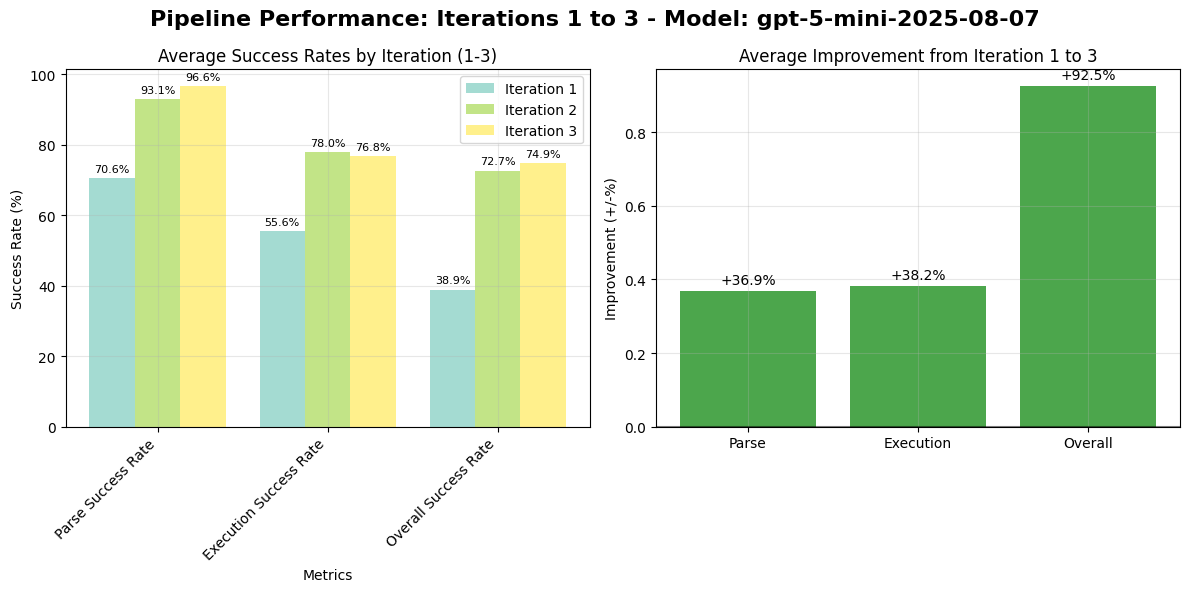


=== Creating plots for model: chatgpt-4o-latest ===


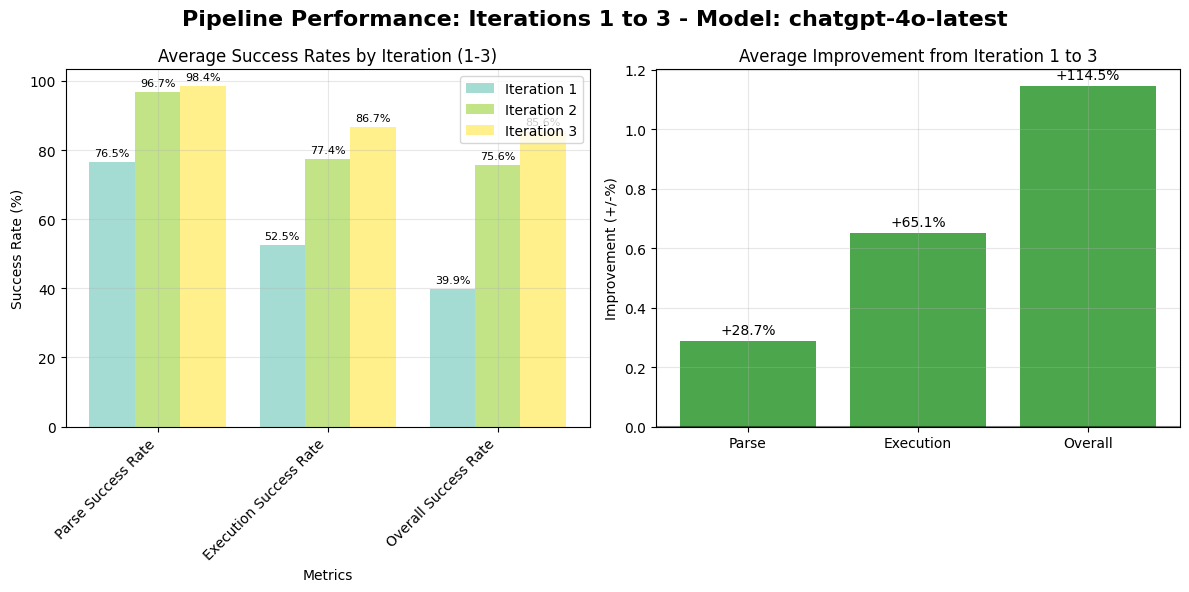


=== Creating plots for model: gpt-5-2025-08-07 ===


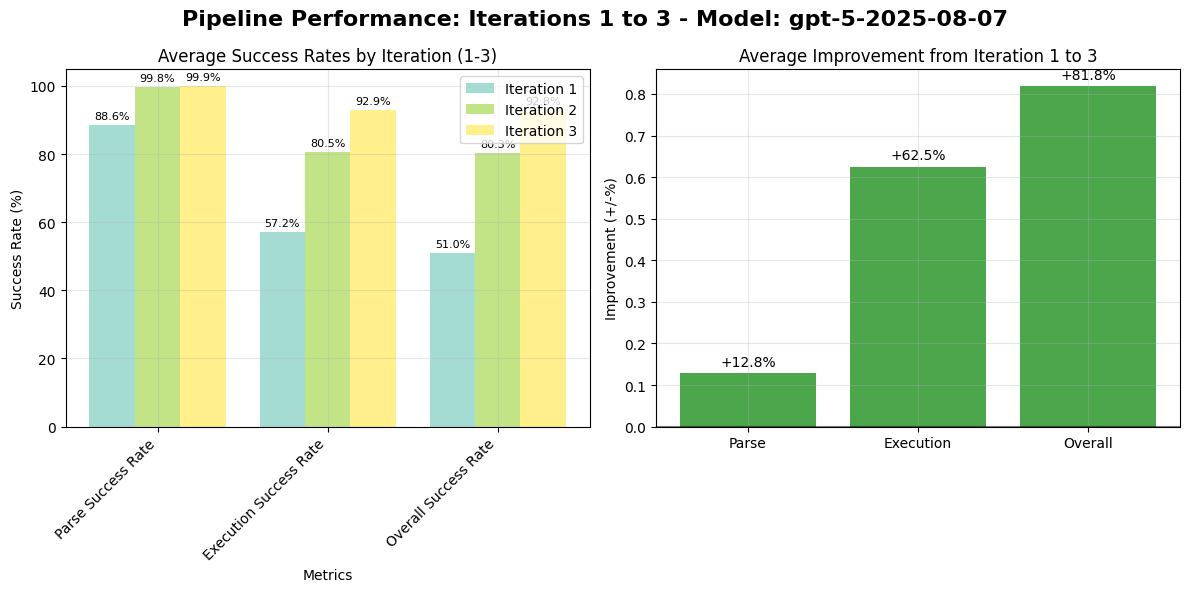


=== Cross-Model Comparison Summary ===


C:\Users\sebad\AppData\Local\Temp\ipykernel_19296\1356363059.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models, rotation=45, ha='right')


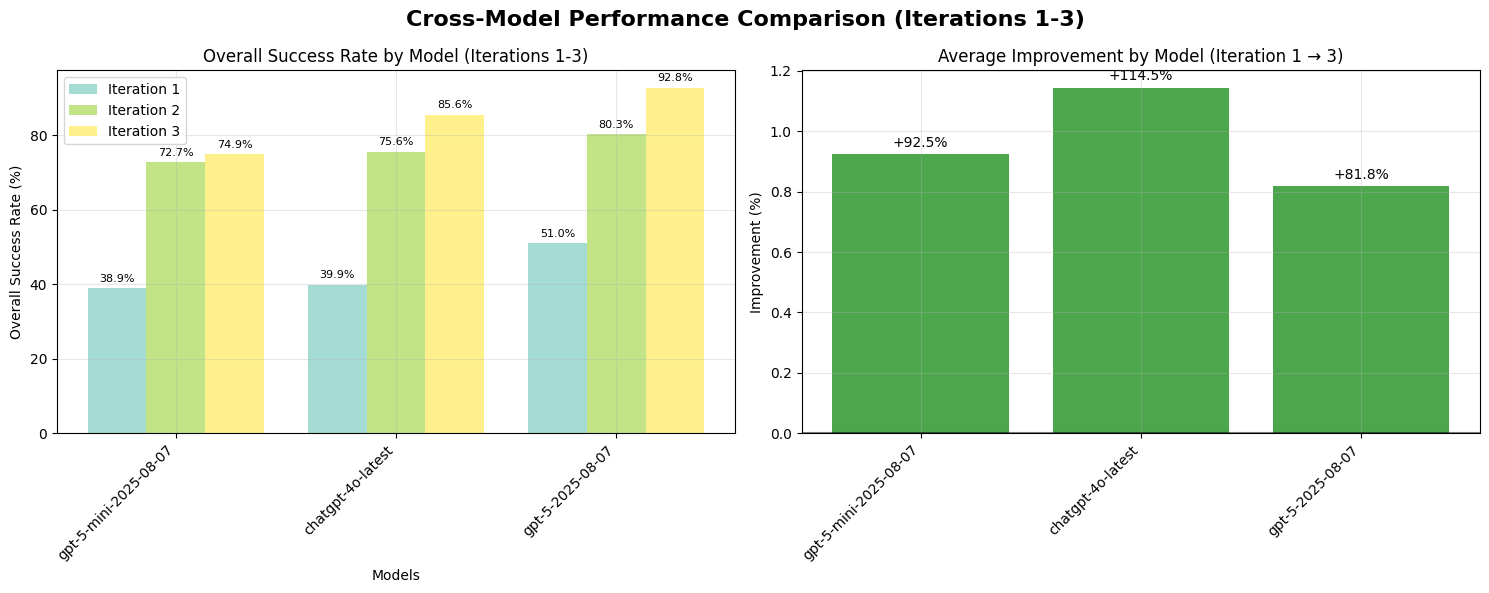

In [22]:
# Create comprehensive comparison visualizations for each model
plt.style.use('default')

def create_model_comparison_plots(model_name, model_info):
    """Create comparison plots for a specific model"""
    df = model_info['df']
    iteration_data = model_info['iteration_data']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    if SHOW_TITLES:
        fig.suptitle(f'Pipeline Performance: Iterations 1 to {TARGET_ITERATION} - Model: {model_name}', fontsize=16, fontweight='bold')

    # Define width for all plots
    width = 0.8 / TARGET_ITERATION  # Adjust width based on number of iterations

    # 1. Success Rates Comparison (Bar Chart) - All iterations
    ax1 = axes[0]
    success_metrics = ['Parse Success Rate', 'Execution Success Rate', 'Overall Success Rate']
    
    # Create data for all iterations using iteration_data (which includes all qualifying conversations)
    iteration_means = {}
    for i in range(1, TARGET_ITERATION + 1):
        # Use iteration_data instead of df to get means across ALL conversations that reached iteration i
        parse_rates = iteration_data[i][f'iteration_{i}_parse_success_rate']
        exec_rates = iteration_data[i][f'iteration_{i}_execution_success_rate']
        overall_rates = iteration_data[i][f'iteration_{i}_overall_success_rate']
        
        iteration_means[f'iteration_{i}'] = [
            np.mean(parse_rates) if parse_rates else 0,
            np.mean(exec_rates) if exec_rates else 0,
            np.mean(overall_rates) if overall_rates else 0
        ]

    x = np.arange(len(success_metrics))
    colors = plt.cm.Set3(np.linspace(0, 1, TARGET_ITERATION))
    
    # Create bars for each iteration
    bars_all = []
    for i, (iter_key, means) in enumerate(iteration_means.items()):
        iteration_num = i + 1
        n_samples = len(iteration_data[iteration_num]['conversation_id'])
        bars = ax1.bar(x + (i - (TARGET_ITERATION-1)/2) * width, means, width, 
                      label=f'Iteration {iteration_num}', alpha=0.8, color=colors[i])
        bars_all.append(bars)

    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_title(f'Average Success Rates by Iteration (1-{TARGET_ITERATION})')
    ax1.set_xticks(x)
    ax1.set_xticklabels(success_metrics, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for bars in bars_all:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    # 2. Improvement Analysis - First vs Last iteration
    ax2 = axes[1]
    
    # Calculate improvement from iteration 1 to TARGET_ITERATION using iteration_data
    first_iter_parse = np.mean(iteration_data[1]['iteration_1_parse_success_rate'])
    first_iter_exec = np.mean(iteration_data[1]['iteration_1_execution_success_rate'])
    first_iter_overall = np.mean(iteration_data[1]['iteration_1_overall_success_rate'])
    
    last_iter_parse = np.mean(iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_parse_success_rate'])
    last_iter_exec = np.mean(iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_execution_success_rate'])
    last_iter_overall = np.mean(iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_overall_success_rate'])
    
    # Calculate relative improvements (avoiding division by zero)
    parse_improvement = (last_iter_parse / first_iter_parse - 1) if first_iter_parse > 0 else 0
    exec_improvement = (last_iter_exec / first_iter_exec - 1) if first_iter_exec > 0 else 0
    overall_improvement = (last_iter_overall / first_iter_overall - 1) if first_iter_overall > 0 else 0

    improvements = [parse_improvement, exec_improvement, overall_improvement]
    improvement_labels = ['Parse', 'Execution', 'Overall']
    colors_imp = ['green' if imp > 0 else 'red' for imp in improvements]

    bars_imp = ax2.bar(improvement_labels, improvements, color=colors_imp, alpha=0.7)
    ax2.set_ylabel('Improvement (+/-%)')
    ax2.set_title(f'Average Improvement from Iteration 1 to {TARGET_ITERATION}')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Add value labels
    for bar, imp in zip(bars_imp, improvements):
        height = bar.get_height()
        ax2.annotate(f'{"+" if height >= 0 else ""}{height*100:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height >= 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    return fig

# Create plots for each model
model_figures = {}
for model_name, model_info in model_data.items():
    if len(model_info['df']) > 0:  # Only create plots if we have data
        print(f"\n=== Creating plots for model: {model_name} ===")
        fig = create_model_comparison_plots(model_name, model_info)
        model_figures[model_name] = fig

# Summary comparison across models
if len(model_data) > 1:
    print(f"\n=== Cross-Model Comparison Summary ===")
    
    # Create summary comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    if SHOW_TITLES:
        fig.suptitle(f'Cross-Model Performance Comparison (Iterations 1-{TARGET_ITERATION})', fontsize=16, fontweight='bold')
    
    models = list(model_data.keys())
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    
    # Overall success rate comparison - All iterations
    ax1 = axes[0]
    iteration_rates = {}
    
    # Collect data for all iterations using iteration_data
    for i in range(1, TARGET_ITERATION + 1):
        iteration_rates[f'iteration_{i}'] = []
        for model in models:
            model_info = model_data[model]
            iteration_data = model_info['iteration_data']
            overall_rates = iteration_data[i][f'iteration_{i}_overall_success_rate']
            iteration_rates[f'iteration_{i}'].append(np.mean(overall_rates) if overall_rates else 0)
    
    x = np.arange(len(models))
    width = 0.8 / TARGET_ITERATION
    colors_iter = plt.cm.Set3(np.linspace(0, 1, TARGET_ITERATION))
    
    # Create bars for each iteration
    bars_all = []
    for i, (iter_key, rates) in enumerate(iteration_rates.items()):
        iteration_num = i + 1
        bars = ax1.bar(x + (i - (TARGET_ITERATION-1)/2) * width, rates, width, 
                      label=f'Iteration {iteration_num}', alpha=0.8, color=colors_iter[i])
        bars_all.append(bars)
    
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Overall Success Rate (%)')
    ax1.set_title(f'Overall Success Rate by Model (Iterations 1-{TARGET_ITERATION})')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bars in bars_all:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
    
    # Improvement comparison - First vs Last iteration
    ax2 = axes[1]
    improvements = []
    
    for model in models:
        model_info = model_data[model]
        iteration_data = model_info['iteration_data']
        
        first_overall = np.mean(iteration_data[1]['iteration_1_overall_success_rate'])
        last_overall = np.mean(iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_overall_success_rate'])
        
        # Calculate relative improvement (avoiding division by zero)
        overall_improvement = (last_overall / first_overall - 1) if first_overall > 0 else 0
        improvements.append(overall_improvement)
    
    colors_imp = ['green' if imp > 0 else 'red' for imp in improvements]
    bars_imp = ax2.bar(models, improvements, color=colors_imp, alpha=0.7)
    ax2.set_ylabel('Improvement (%)')
    ax2.set_title(f'Average Improvement by Model (Iteration 1 → {TARGET_ITERATION})')
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Add value labels
    for bar, imp in zip(bars_imp, improvements):
        height = bar.get_height()
        ax2.annotate(f'{"+" if height >= 0 else ""}{height*100:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height >= 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("Only one model found - no cross-model comparison available")


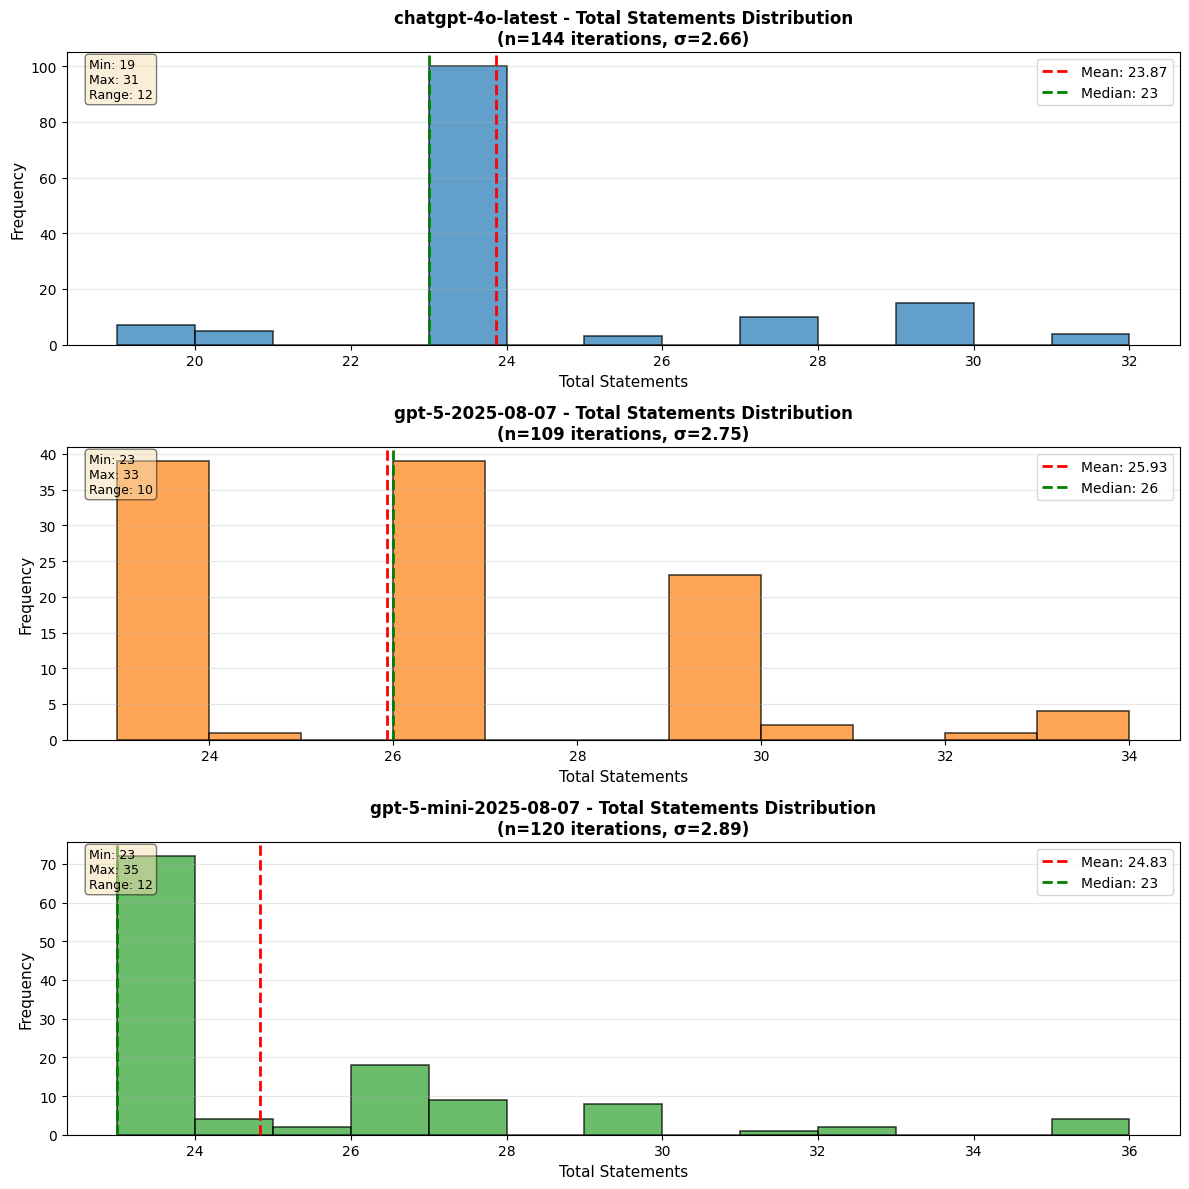

Total Statements Distribution Summary (All Iterations)

chatgpt-4o-latest:
  Total iterations: 144
  Mean: 23.87
  Median: 23
  Std Dev: 2.66
  Min: 19
  Max: 31
  Range: 12
  Variance: 7.06

gpt-5-2025-08-07:
  Total iterations: 109
  Mean: 25.93
  Median: 26
  Std Dev: 2.75
  Min: 23
  Max: 33
  Range: 10
  Variance: 7.57

gpt-5-mini-2025-08-07:
  Total iterations: 120
  Mean: 24.83
  Median: 23
  Std Dev: 2.89
  Min: 23
  Max: 35
  Range: 12
  Variance: 8.37


In [23]:
# Histogram of total_statements distribution for each model across ALL iterations

# Collect total_statements from all iterations for each model
model_statements_all = defaultdict(list)

for conv_id, execution in executions.items():
    model = execution.get('model', 'chatgpt-4o-latest')
    
    # Get total_statements from ALL iterations
    if execution.get('iteration_results'):
        for iteration in execution['iteration_results']:
            total_stmts = iteration.get('total_statements', 0)
            model_statements_all[model].append(total_stmts)

# Create figure with subplots for each model
models = sorted(model_statements_all.keys())
n_models = len(models)
fig, axes = plt.subplots(n_models, 1, figsize=(12, 4*n_models))


# Handle case of single model (axes won't be an array)
if n_models == 1:
    axes = [axes]

# Create histogram for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, (model, ax) in enumerate(zip(models, axes)):
    statements = model_statements_all[model]
    
    # Calculate statistics
    mean_val = np.mean(statements)
    median_val = np.median(statements)
    std_val = np.std(statements)
    
    # Create histogram
    n, bins, patches = ax.hist(statements, bins=range(min(statements), max(statements) + 2), 
                               alpha=0.7, color=colors[idx % len(colors)], edgecolor='black', linewidth=1.2)
    
    # Add vertical lines for mean and median
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.0f}')
    
    # Set title and labels
    if SHOW_TITLES:
        ax.set_title(f'{model} - Total Statements Distribution\n'
                    f'(n={len(statements)} iterations, σ={std_val:.2f})', 
                    fontsize=12, fontweight='bold')
    ax.set_xlabel('Total Statements', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistics text box
    stats_text = f'Min: {min(statements)}\nMax: {max(statements)}\nRange: {max(statements) - min(statements)}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 80)
print("Total Statements Distribution Summary (All Iterations)")
print("=" * 80)
for model in models:
    statements = model_statements_all[model]
    print(f"\n{model}:")
    print(f"  Total iterations: {len(statements)}")
    print(f"  Mean: {np.mean(statements):.2f}")
    print(f"  Median: {np.median(statements):.0f}")
    print(f"  Std Dev: {np.std(statements):.2f}")
    print(f"  Min: {min(statements)}")
    print(f"  Max: {max(statements)}")
    print(f"  Range: {max(statements) - min(statements)}")
    print(f"  Variance: {np.var(statements):.2f}")


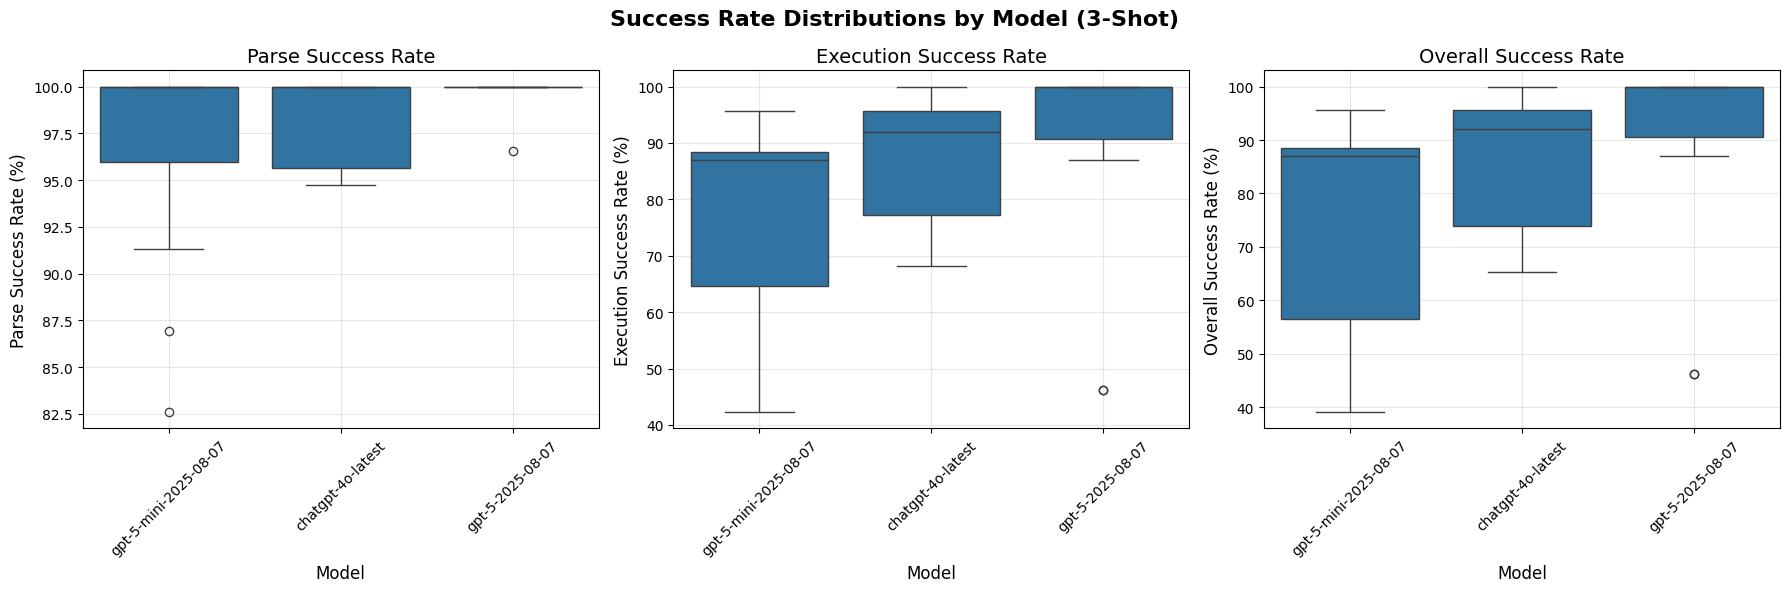

Success Rate Summary by Model (In 3 requests):




,Model,n,Metric,Mean,Median,Std,P25,P75,P90,P95,P99
0,gpt-5-mini-2025-08-07,15,Parse,96.6,100.0,5.3,96.0,100.0,100.0,100.0,100.0
1,gpt-5-mini-2025-08-07,15,Execution,76.8,87.0,19.1,64.7,88.4,93.9,95.7,95.7
2,gpt-5-mini-2025-08-07,15,Overall,74.9,87.0,20.9,56.5,88.4,93.9,95.7,95.7
3,chatgpt-4o-latest,23,Parse,98.4,100.0,2.1,95.7,100.0,100.0,100.0,100.0
4,chatgpt-4o-latest,23,Execution,86.7,92.0,11.4,77.3,95.7,96.2,99.6,100.0
5,chatgpt-4o-latest,23,Overall,85.6,92.0,12.8,73.9,95.7,96.2,99.6,100.0
6,gpt-5-2025-08-07,31,Parse,99.9,100.0,0.6,100.0,100.0,100.0,100.0,100.0
7,gpt-5-2025-08-07,31,Execution,92.9,100.0,13.3,90.7,100.0,100.0,100.0,100.0
8,gpt-5-2025-08-07,31,Overall,92.8,100.0,13.2,90.7,100.0,100.0,100.0,100.0


In [24]:
# Create grid of boxplots for different success rates by model
import seaborn as sns

# Prepare data for boxplots - using target iteration from iteration_data
parse_data = []
execution_data = []
overall_data = []

for model_name, model_info in model_data.items():
    iteration_data = model_info['iteration_data']
    
    # Parse success rates
    for rate in iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_parse_success_rate']:
        parse_data.append({
            'Model': model_name,
            'Parse Success Rate': rate
        })
    
    # Execution success rates
    for rate in iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_execution_success_rate']:
        execution_data.append({
            'Model': model_name,
            'Execution Success Rate': rate
        })
    
    # Overall success rates
    for rate in iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_overall_success_rate']:
        overall_data.append({
            'Model': model_name,
            'Overall Success Rate': rate
        })

# Convert to DataFrames
parse_df = pd.DataFrame(parse_data)
execution_df = pd.DataFrame(execution_data)
overall_df = pd.DataFrame(overall_data)

# Create the grid of boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
if SHOW_TITLES:
    fig.suptitle(f'Success Rate Distributions by Model ({TARGET_ITERATION}-Shot)', fontsize=16, fontweight='bold')

# Plot 1: Parse Success Rate
sns.boxplot(data=parse_df, x='Model', y='Parse Success Rate', ax=axes[0])
axes[0].set_title('Parse Success Rate', fontsize=14)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Parse Success Rate (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Plot 2: Execution Success Rate
sns.boxplot(data=execution_df, x='Model', y='Execution Success Rate', ax=axes[1])
axes[1].set_title('Execution Success Rate', fontsize=14)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Execution Success Rate (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Plot 3: Overall Success Rate
sns.boxplot(data=overall_df, x='Model', y='Overall Success Rate', ax=axes[2])
axes[2].set_title('Overall Success Rate', fontsize=14)
axes[2].set_xlabel('Model', fontsize=12)
axes[2].set_ylabel('Overall Success Rate (%)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for target iteration
print(f"Success Rate Summary by Model (In {TARGET_ITERATION} request{'s' if TARGET_ITERATION > 1 else ''}):")
print("="*60)

# Collect data for all models in a list
summary_data = []

for model_name, model_info in model_data.items():
    iteration_data = model_info['iteration_data']
    n_samples = len(iteration_data[TARGET_ITERATION]['conversation_id'])
    
    # Parse success rates
    parse_rates = iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_parse_success_rate']
    parse_stats = {
        'Model': model_name,
        'n': n_samples,
        'Metric': 'Parse',
        'Mean': np.mean(parse_rates),
        'Median': np.median(parse_rates),
        'Std': np.std(parse_rates),
        'P25': np.percentile(parse_rates, 25),
        'P75': np.percentile(parse_rates, 75),
        'P90': np.percentile(parse_rates, 90),
        'P95': np.percentile(parse_rates, 95),
        'P99': np.percentile(parse_rates, 99)
    }
    summary_data.append(parse_stats)
    
    # Execution success rates
    exec_rates = iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_execution_success_rate']
    exec_stats = {
        'Model': model_name,
        'n': n_samples,
        'Metric': 'Execution',
        'Mean': np.mean(exec_rates),
        'Median': np.median(exec_rates),
        'Std': np.std(exec_rates),
        'P25': np.percentile(exec_rates, 25),
        'P75': np.percentile(exec_rates, 75),
        'P90': np.percentile(exec_rates, 90),
        'P95': np.percentile(exec_rates, 95),
        'P99': np.percentile(exec_rates, 99)
    }
    summary_data.append(exec_stats)
    
    # Overall success rates
    overall_rates = iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_overall_success_rate']
    overall_stats = {
        'Model': model_name,
        'n': n_samples,
        'Metric': 'Overall',
        'Mean': np.mean(overall_rates),
        'Median': np.median(overall_rates),
        'Std': np.std(overall_rates),
        'P25': np.percentile(overall_rates, 25),
        'P75': np.percentile(overall_rates, 75),
        'P90': np.percentile(overall_rates, 90),
        'P95': np.percentile(overall_rates, 95),
        'P99': np.percentile(overall_rates, 99)
    }
    summary_data.append(overall_stats)

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Format percentage columns to 1 decimal place
percentage_cols = ['Mean', 'Median', 'Std', 'P25', 'P75', 'P90', 'P95', 'P99']
for col in percentage_cols:
    summary_df[col] = summary_df[col].round(1)

# Display the table
print("\n")
display(summary_df)


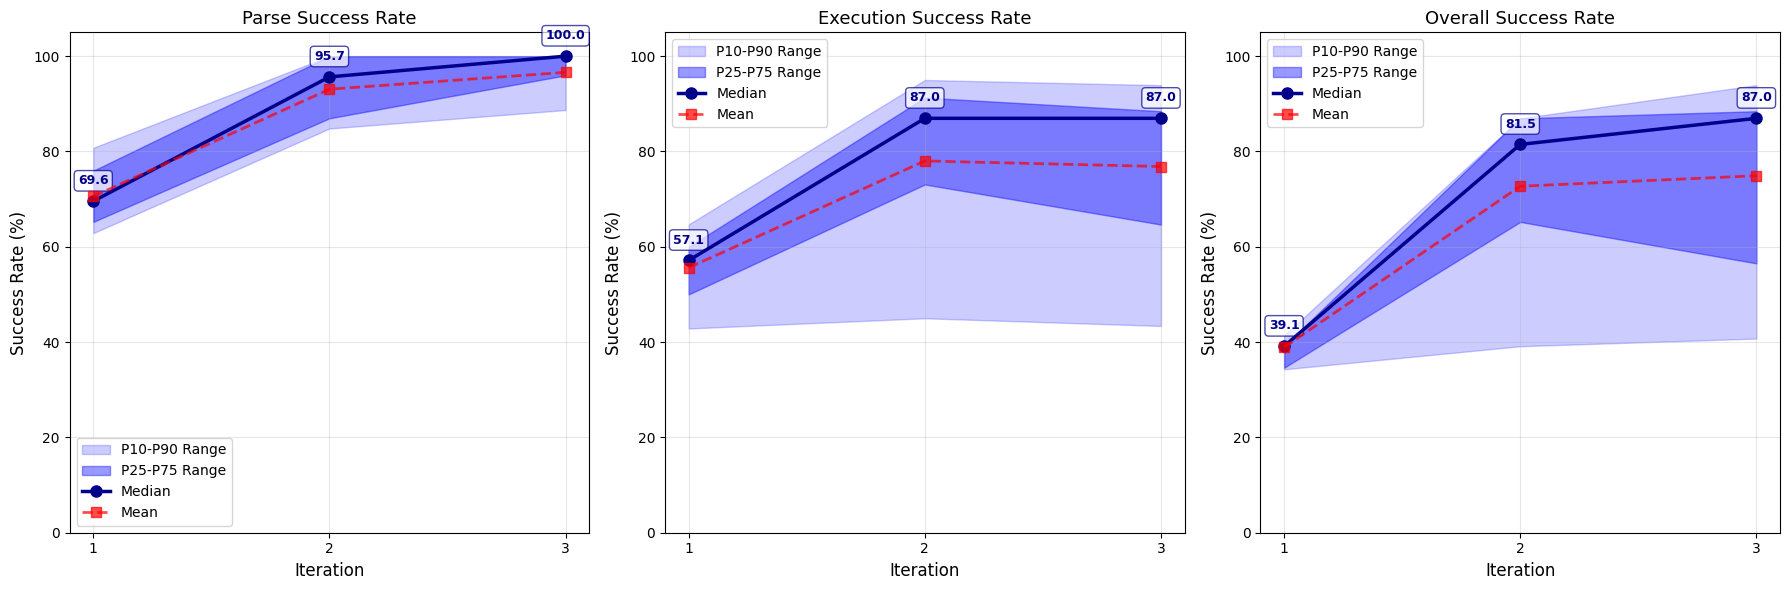

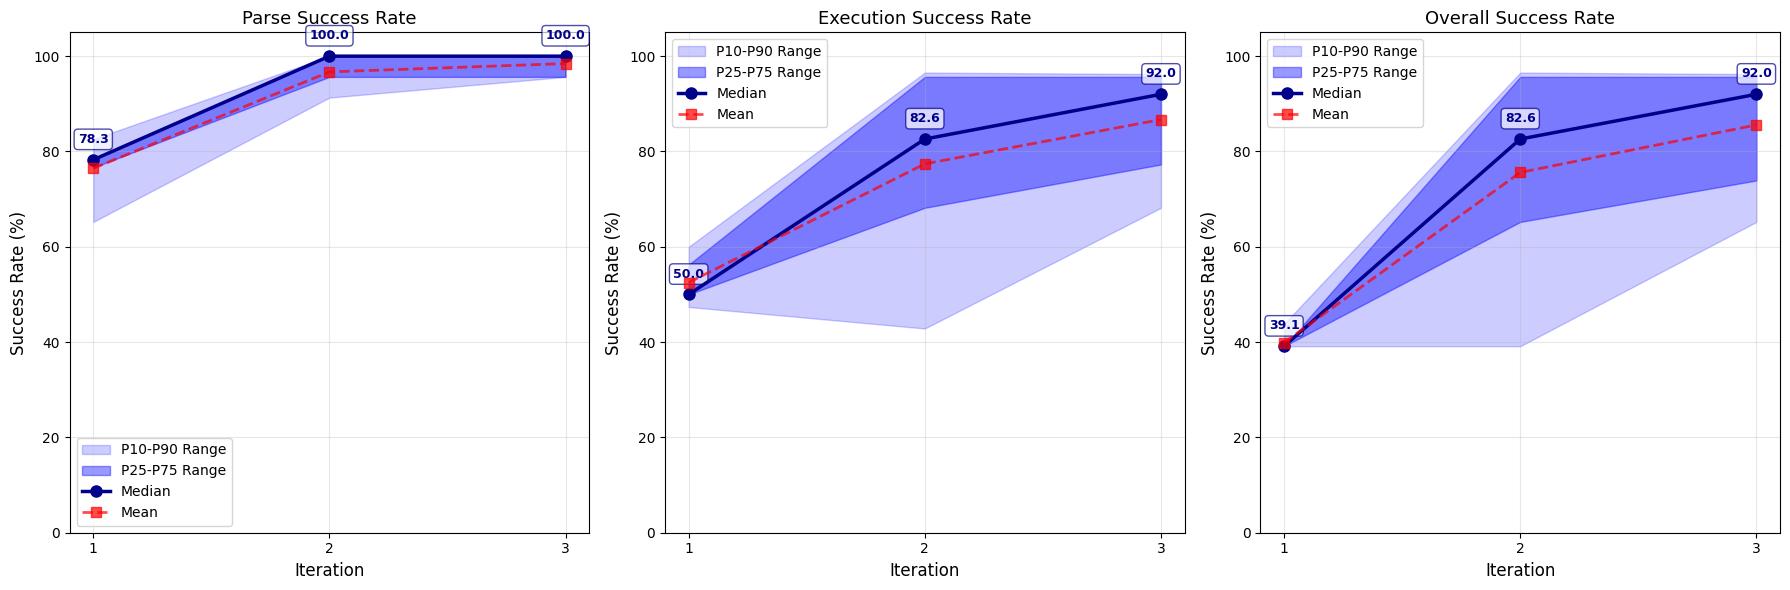

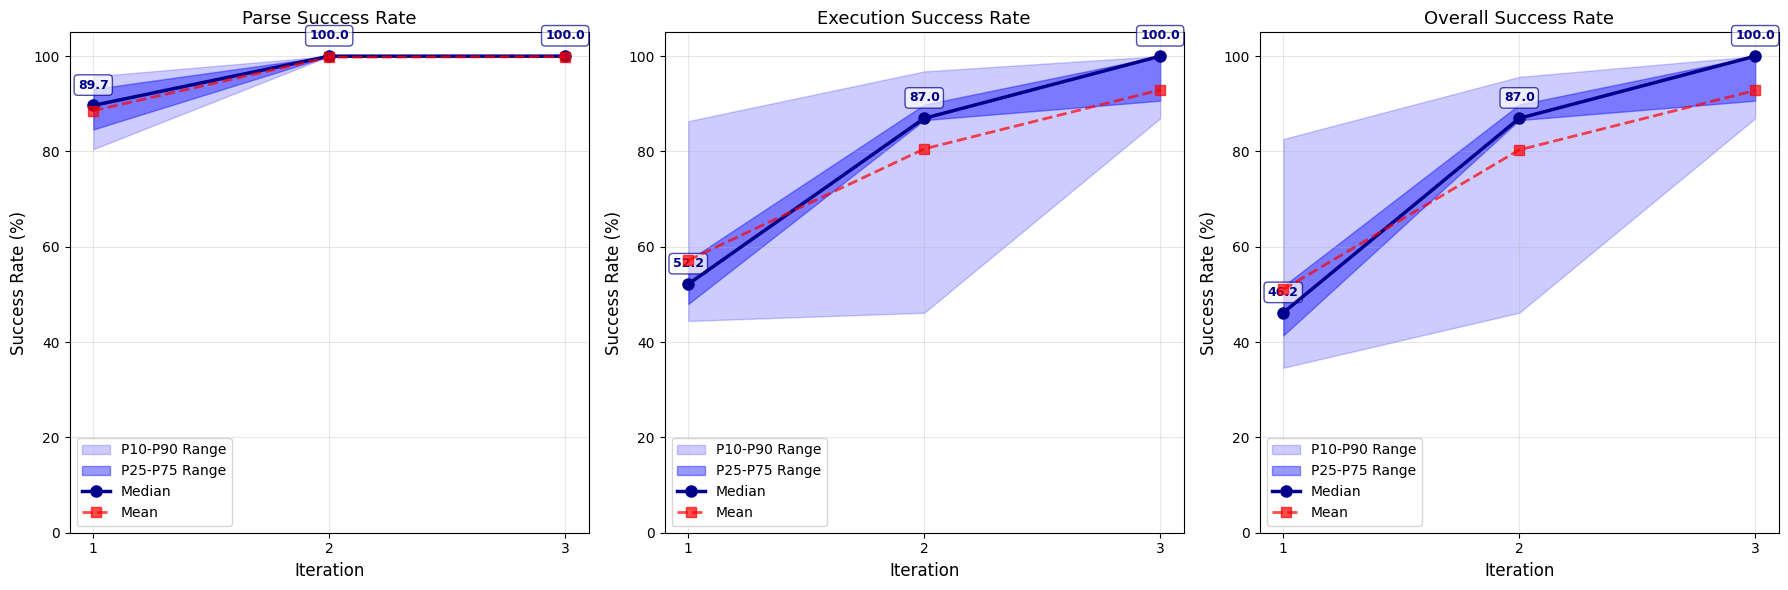

In [25]:
# Displays P25-P75 as boxes and P10-P90 as whiskers

metrics = ['parse', 'execution', 'overall']
metric_names = ['Parse Success Rate', 'Execution Success Rate', 'Overall Success Rate']

for model_name, model_info in model_data.items():

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    iteration_data = model_info['iteration_data']
    
    for metric_idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        ax = axes[metric_idx]
        
        # Collect percentile data for each iteration
        iterations = list(range(1, TARGET_ITERATION + 1))
        means = []
        medians = []
        p10s = []
        p25s = []
        p75s = []
        p90s = []
        
        for i in iterations:
            rates = iteration_data[i][f'iteration_{i}_{metric}_success_rate']
            means.append(np.mean(rates))
            medians.append(np.median(rates))
            p10s.append(np.percentile(rates, 10))
            p25s.append(np.percentile(rates, 25))
            p75s.append(np.percentile(rates, 75))
            p90s.append(np.percentile(rates, 90))
        
        # Plot the percentile ranges
        x = np.array(iterations)
        
        # P10-P90 range (lighter shade)
        ax.fill_between(x, p10s, p90s, alpha=0.2, color='blue', label='P10-P90 Range')
        
        # P25-P75 range (darker shade) - IQR
        ax.fill_between(x, p25s, p75s, alpha=0.4, color='blue', label='P25-P75 Range')
        
        # Median line
        ax.plot(x, medians, 'o-', linewidth=2.5, markersize=8, color='darkblue', 
                label='Median', zorder=5)
        
        # Mean line
        ax.plot(x, means, 's--', linewidth=2, markersize=7, color='red', 
                label='Mean', alpha=0.7, zorder=5)
        
        # Numeric labels for median values
        for i, (iter_x, median_val) in enumerate(zip(x, medians)):
            ax.annotate(f'{median_val:.1f}',
                       xy=(iter_x, median_val),
                       xytext=(0, 10),
                       textcoords="offset points",
                       ha='center', va='bottom',
                       fontsize=9, fontweight='bold',
                       color='darkblue',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                edgecolor='darkblue', alpha=0.7))
        
        ax.set_xlabel('Iteration', fontsize=12)
        ax.set_ylabel('Success Rate (%)', fontsize=12)
        ax.set_title(f'{metric_name}', fontsize=13)
        ax.set_xticks(iterations)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 105])
    
    plt.tight_layout()
    plt.show()

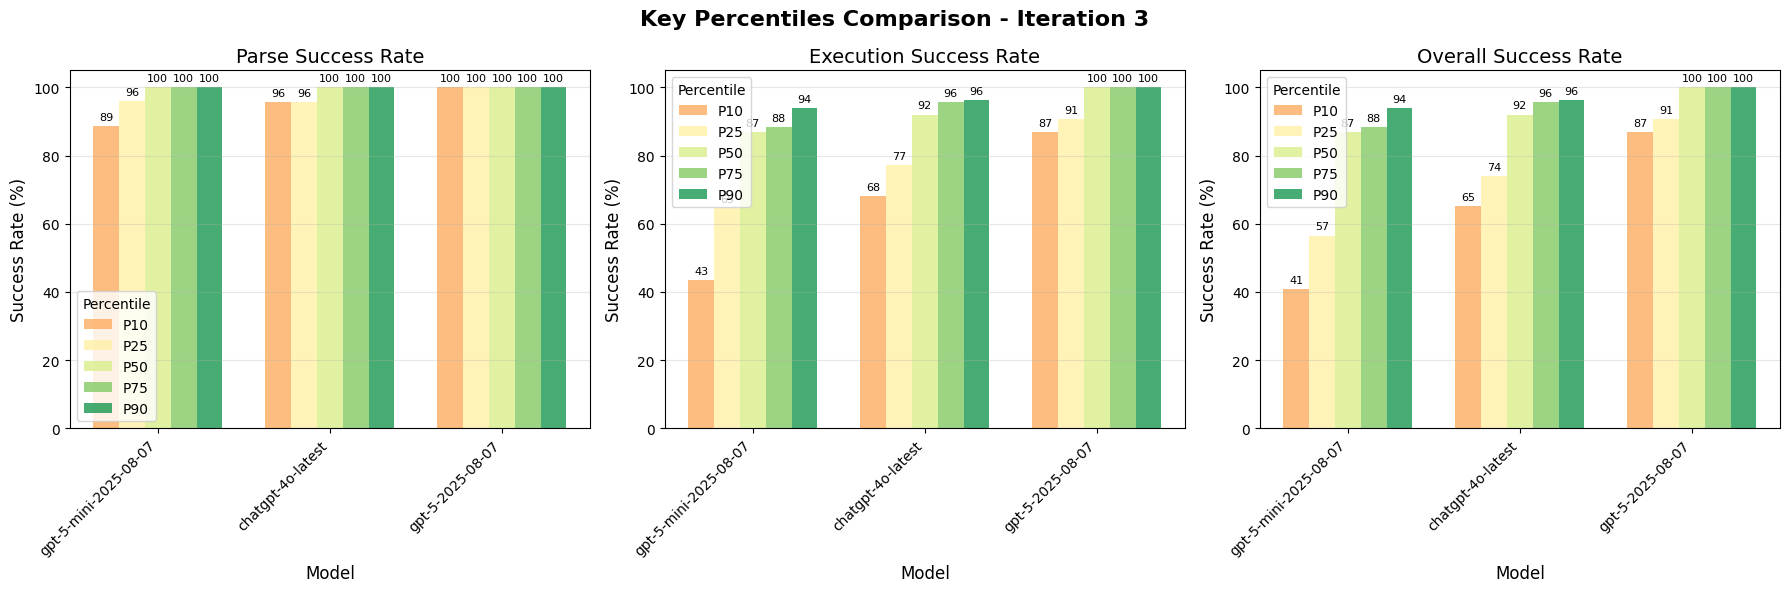

Percentile Comparison Chart Interpretation:
- Each bar represents a specific percentile (P10, P25, P50, P75, P90)
- Higher values = better performance at that percentile
- Larger spread between P10 and P90 = more variable performance
- All bars at similar heights = consistent, reliable performance


In [26]:
# 3. BONUS: Percentile Comparison Bar Chart
# Compare specific percentiles across models for Iteration TARGET_ITERATION

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Key Percentiles Comparison - Iteration {TARGET_ITERATION}', fontsize=16, fontweight='bold')

metrics = ['parse', 'execution', 'overall']
metric_names = ['Parse Success Rate', 'Execution Success Rate', 'Overall Success Rate']

for metric_idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[metric_idx]
    
    models = list(model_data.keys())
    percentiles_to_show = [10, 25, 50, 75, 90]
    n_percentiles = len(percentiles_to_show)
    
    # Collect percentile data for all models
    percentile_data = {p: [] for p in percentiles_to_show}
    
    for model_name, model_info in model_data.items():
        iteration_data = model_info['iteration_data']
        rates = iteration_data[TARGET_ITERATION][f'iteration_{TARGET_ITERATION}_{metric}_success_rate']
        
        for p in percentiles_to_show:
            percentile_data[p].append(np.percentile(rates, p))
    
    # Create grouped bar chart
    x = np.arange(len(models))
    width = 0.15
    colors_percentiles = plt.cm.RdYlGn(np.linspace(0.3, 0.9, n_percentiles))
    
    for i, p in enumerate(percentiles_to_show):
        offset = (i - n_percentiles/2 + 0.5) * width
        bars = ax.bar(x + offset, percentile_data[p], width, 
                     label=f'P{p}', color=colors_percentiles[i], alpha=0.8)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.0f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Success Rate (%)', fontsize=12)
    ax.set_title(metric_name, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(title='Percentile')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print("Percentile Comparison Chart Interpretation:")
print("- Each bar represents a specific percentile (P10, P25, P50, P75, P90)")
print("- Higher values = better performance at that percentile")
print("- Larger spread between P10 and P90 = more variable performance")
print("- All bars at similar heights = consistent, reliable performance")


Model: gpt-5-mini-2025-08-07
RAG-enabled runs: 37
Non-RAG runs: 51


C:\Users\sebad\AppData\Local\Temp\ipykernel_19296\2988063529.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(configs, rotation=45, ha='right')
C:\Users\sebad\AppData\Local\Temp\ipykernel_19296\2988063529.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(configs, rotation=45, ha='right')
C:\Users\sebad\AppData\Local\Temp\ipykernel_19296\2988063529.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(configs, rotation=45, ha='right')


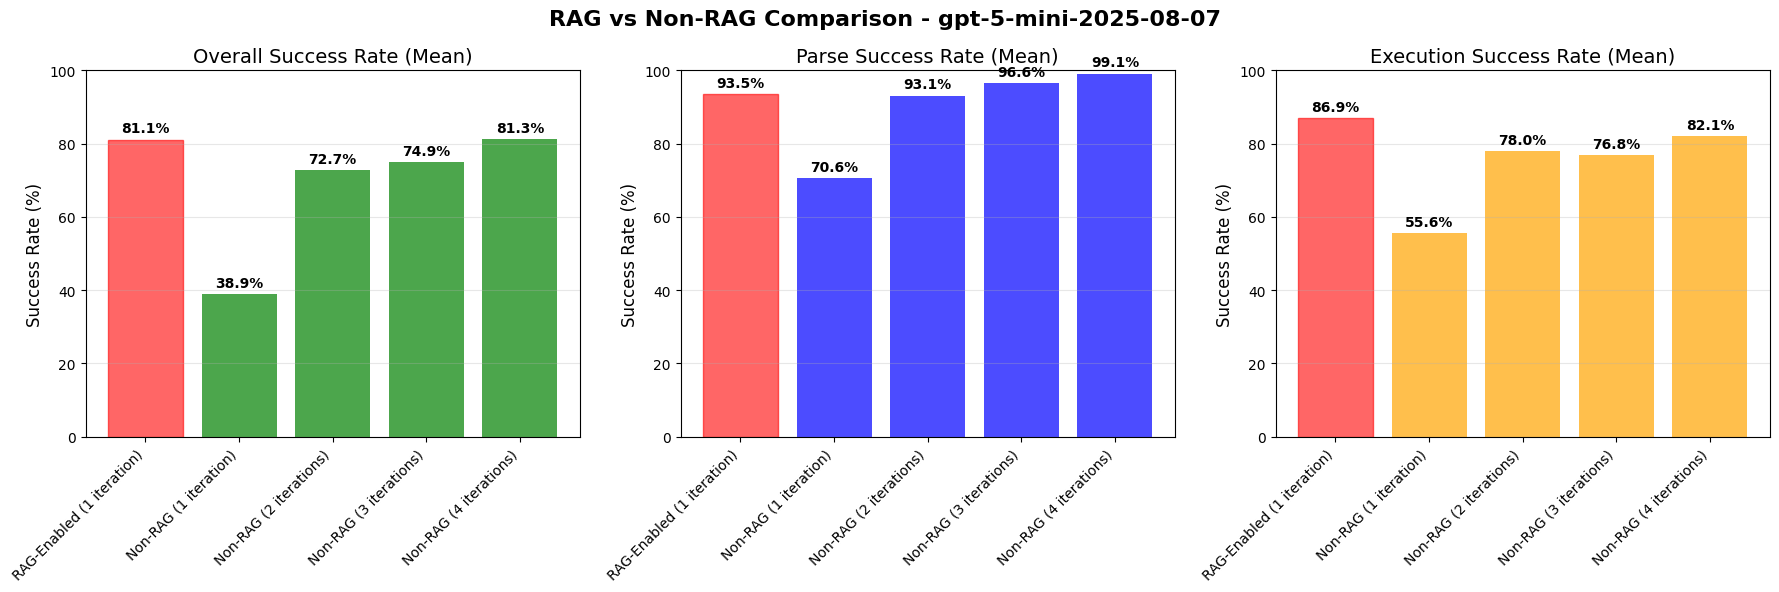

In [27]:
# RAG vs Non-RAG Comparison for gpt-5-mini-2025-08-07
# Compare multi-iteration non-RAG runs with 1-iteration RAG-enabled runs

# Load data again without RAG filtering
with open('pipeline_results(0).json', 'r') as f:
    all_data = json.load(f)

all_executions = all_data['executions']

# Filter for gpt-5-mini-2025-08-07 model only
target_model = 'gpt-5-mini-2025-08-07'

# Separate RAG-enabled and non-RAG runs
rag_runs = []
non_rag_runs = []

for conv_id, execution in all_executions.items():
    if execution.get('model', '') == target_model:
        if execution.get('rag_enabled', False):
            rag_runs.append((conv_id, execution))
        else:
            non_rag_runs.append((conv_id, execution))

print(f"Model: {target_model}")
print(f"RAG-enabled runs: {len(rag_runs)}")
print(f"Non-RAG runs: {len(non_rag_runs)}")

# Analyze RAG runs (1 iteration)
rag_metrics = {
    'parse_rates': [],
    'execution_rates': [],
    'overall_rates': [],
    'total_statements': [],
    'parse_errors': [],
    'execution_errors': [],
    'success_count': 0
}

for conv_id, execution in rag_runs:
    if len(execution['iteration_results']) >= 1:
        iter_data = execution['iteration_results'][0]  # First iteration
        rag_metrics['parse_rates'].append(iter_data['parse_success_rate'])
        rag_metrics['execution_rates'].append(iter_data['execution_success_rate'])
        rag_metrics['overall_rates'].append(iter_data['overall_success_rate'])
        rag_metrics['total_statements'].append(iter_data['total_statements'])
        rag_metrics['parse_errors'].append(iter_data['parse_errors'])
        rag_metrics['execution_errors'].append(iter_data['execution_errors'])
        if iter_data['success']:
            rag_metrics['success_count'] += 1

# Analyze non-RAG runs by iteration
# Get the maximum iterations available
max_iterations = max([len(exec['iteration_results']) for _, exec in non_rag_runs]) if non_rag_runs else 0

non_rag_metrics_by_iteration = {}
for i in range(1, max_iterations + 1):
    non_rag_metrics_by_iteration[i] = {
        'parse_rates': [],
        'execution_rates': [],
        'overall_rates': [],
        'total_statements': [],
        'parse_errors': [],
        'execution_errors': [],
        'success_count': 0
    }
    
    for conv_id, execution in non_rag_runs:
        if len(execution['iteration_results']) >= i:
            iter_data = execution['iteration_results'][i-1]
            non_rag_metrics_by_iteration[i]['parse_rates'].append(iter_data['parse_success_rate'])
            non_rag_metrics_by_iteration[i]['execution_rates'].append(iter_data['execution_success_rate'])
            non_rag_metrics_by_iteration[i]['overall_rates'].append(iter_data['overall_success_rate'])
            non_rag_metrics_by_iteration[i]['total_statements'].append(iter_data['total_statements'])
            non_rag_metrics_by_iteration[i]['parse_errors'].append(iter_data['parse_errors'])
            non_rag_metrics_by_iteration[i]['execution_errors'].append(iter_data['execution_errors'])
            if iter_data['success']:
                non_rag_metrics_by_iteration[i]['success_count'] += 1

# Create comparison table
comparison_data = []

# Add RAG data (1 iteration)
if len(rag_runs) > 0:
    comparison_data.append({
        'Configuration': 'RAG-Enabled (1 iteration)',
        'N Samples': len(rag_metrics['parse_rates']),
        'Parse Success (Mean)': np.mean(rag_metrics['parse_rates']),
        'Parse Success (Median)': np.median(rag_metrics['parse_rates']),
        'Parse Success (Std)': np.std(rag_metrics['parse_rates']),
        'Execution Success (Mean)': np.mean(rag_metrics['execution_rates']),
        'Execution Success (Median)': np.median(rag_metrics['execution_rates']),
        'Execution Success (Std)': np.std(rag_metrics['execution_rates']),
        'Overall Success (Mean)': np.mean(rag_metrics['overall_rates']),
        'Overall Success (Median)': np.median(rag_metrics['overall_rates']),
        'Overall Success (Std)': np.std(rag_metrics['overall_rates']),
        'Success Count': rag_metrics['success_count'],
        'Success Rate': (rag_metrics['success_count'] / len(rag_metrics['parse_rates']) * 100) if len(rag_metrics['parse_rates']) > 0 else 0
    })

# Add non-RAG data for each iteration
for i in range(1, max_iterations + 1):
    if len(non_rag_metrics_by_iteration[i]['parse_rates']) > 0:
        comparison_data.append({
            'Configuration': f'Non-RAG ({i} iteration{"s" if i > 1 else ""})',
            'N Samples': len(non_rag_metrics_by_iteration[i]['parse_rates']),
            'Parse Success (Mean)': np.mean(non_rag_metrics_by_iteration[i]['parse_rates']),
            'Parse Success (Median)': np.median(non_rag_metrics_by_iteration[i]['parse_rates']),
            'Parse Success (Std)': np.std(non_rag_metrics_by_iteration[i]['parse_rates']),
            'Execution Success (Mean)': np.mean(non_rag_metrics_by_iteration[i]['execution_rates']),
            'Execution Success (Median)': np.median(non_rag_metrics_by_iteration[i]['execution_rates']),
            'Execution Success (Std)': np.std(non_rag_metrics_by_iteration[i]['execution_rates']),
            'Overall Success (Mean)': np.mean(non_rag_metrics_by_iteration[i]['overall_rates']),
            'Overall Success (Median)': np.median(non_rag_metrics_by_iteration[i]['overall_rates']),
            'Overall Success (Std)': np.std(non_rag_metrics_by_iteration[i]['overall_rates']),
            'Success Count': non_rag_metrics_by_iteration[i]['success_count'],
            'Success Rate': (non_rag_metrics_by_iteration[i]['success_count'] / len(non_rag_metrics_by_iteration[i]['parse_rates']) * 100) if len(non_rag_metrics_by_iteration[i]['parse_rates']) > 0 else 0
        })

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Round percentage columns
percentage_cols = ['Parse Success (Mean)', 'Parse Success (Median)', 'Parse Success (Std)',
                   'Execution Success (Mean)', 'Execution Success (Median)', 'Execution Success (Std)',
                   'Overall Success (Mean)', 'Overall Success (Median)', 'Overall Success (Std)',
                   'Success Rate']
for col in percentage_cols:
    comparison_df[col] = comparison_df[col].round(1)

# Create visual comparison for key metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'RAG vs Non-RAG Comparison - {target_model}', fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('Overall Success (Mean)', 'Overall Success Rate (Mean)', 'green'),
    ('Parse Success (Mean)', 'Parse Success Rate (Mean)', 'blue'),
    ('Execution Success (Mean)', 'Execution Success Rate (Mean)', 'orange')
]

for idx, (metric, title, color) in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    configs = comparison_df['Configuration']
    values = comparison_df[metric]
    
    bars = ax.bar(configs, values, color=color, alpha=0.7)
    
    # Highlight RAG bar differently
    bars[0].set_color('red')
    bars[0].set_alpha(0.6)
    
    ax.set_ylabel('Success Rate (%)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticklabels(configs, rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 100])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
